# Things to do
1. Add temperature to sim
2. Use temperature to get speed of sound in the water
3. Use speed of sound in water and velocity equations to get upstream and downstream times

In [1]:
import os
import time, gc, json, warnings
from datetime import datetime
import pandas as pd
import numpy as np
import math
import qexpy as q
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.dataprocessing.transformers import Scaler
from darts.models import TCNModel

/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet("../../wdn_sim/output/raw/small/20250807/light_100h_7d_20250807_111230_all_houses.parquet", engine="pyarrow")
df.head()

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,0.785398,25.0,4,Copper,False,None
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,0.785398,25.0,4,Copper,False,None
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,0.785398,25.0,4,Copper,False,None
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,0.785398,25.0,4,Copper,False,None
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,0.785398,25.0,4,Copper,False,None


In [3]:
original_df = df.copy()

In [4]:
df.describe()

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections
count,6048100,6.048100e+06,6.042018e+06,6.042018e+06,6.048100e+06,6.048100e+06,6048100.0,6.048100e+06,6.048100e+06,6.042011e+06,6.048100e+06,6048100.0,6.048100e+06
mean,2025-07-05 00:57:36,5.050000e+01,5.287293e-04,8.380519e+00,1.075125e+00,2.642267e+03,300.0,7.874769e-05,7.880549e-05,-5.796115e-08,7.853982e-01,25.0,2.920000e+00
min,2025-01-15 00:00:00,1.000000e+00,-4.056561e-04,-6.429771e+00,0.000000e+00,7.384132e-04,300.0,7.256850e-05,7.877597e-05,-4.391344e-05,7.853982e-01,25.0,2.000000e+00
25%,2025-04-22 00:00:00,2.575000e+01,3.410779e-05,5.406188e-01,6.945327e-02,1.976122e+03,300.0,7.877187e-05,7.877800e-05,-8.532535e-09,7.853982e-01,25.0,2.000000e+00
50%,2025-07-04 00:00:00,5.050000e+01,5.175268e-05,8.202955e-01,1.053594e-01,2.422598e+03,300.0,7.877330e-05,7.877896e-05,-5.664738e-09,7.853982e-01,25.0,2.000000e+00
75%,2025-09-19 12:00:00,7.525000e+01,7.813708e-05,1.238496e+00,1.586457e-01,3.271705e+03,300.0,7.877427e-05,7.878040e-05,-3.733851e-09,7.853982e-01,25.0,4.000000e+00
max,2026-01-02 00:00:00,1.000000e+02,3.316230e-01,5.256324e+03,2.507699e+02,2.736886e+04,300.0,7.877632e-05,8.614491e-05,2.529094e-10,7.853982e-01,25.0,4.000000e+00
std,NaN,2.886607e+01,3.451767e-03,5.471155e+01,6.998187e+00,1.564938e+03,0.0,1.836040e-07,1.928118e-07,3.805336e-07,2.892964e-11,0.0,9.967949e-01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6048100 entries, 0 to 6048099
Data columns (total 16 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   timestamp                         datetime64[ms]
 1   house_id                          int32         
 2   flow_m3_s                         float64       
 3   flow_gpm                          float64       
 4   velocity                          float64       
 5   totalizer                         float64       
 6   pressure                          float64       
 7   downstream_wave_time              float64       
 8   upstream_wave_time                float64       
 9   delta_t_raw                       float64       
 10  theta                             float64       
 11  pipe_diameter                     float64       
 12  number_of_ultrasonic_reflections  int32         
 13  pipe_material                     object        
 14  leak              

In [6]:
df.isnull().sum()

timestamp                                 0
house_id                                  0
flow_m3_s                              6082
flow_gpm                               6082
velocity                                  0
totalizer                                 0
pressure                                  0
downstream_wave_time                      0
upstream_wave_time                        0
delta_t_raw                            6089
theta                                     0
pipe_diameter                             0
number_of_ultrasonic_reflections          0
pipe_material                             0
leak                                      0
location                            5932164
dtype: int64

## Investigating Nulls

In [7]:
df[df['delta_t_raw'].isna()]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location
632,2025-10-04 01:45:20,30,0.000067,1.069194,0.136726,35.463811,300.0,0.000079,0.000079,NaN,0.785398,25.0,4,Copper,False,None
3061,2025-10-04 08:30:10,30,0.038036,602.889542,77.484688,1020.746931,300.0,0.000077,0.000081,NaN,0.785398,25.0,4,Copper,False,None
3931,2025-10-04 10:55:10,30,0.000062,0.983101,0.127617,1412.639597,300.0,0.000079,0.000079,NaN,0.785398,25.0,4,Copper,False,None
5138,2025-10-04 14:16:20,30,0.000064,1.016987,0.129115,1676.226562,300.0,0.000079,0.000079,NaN,0.785398,25.0,4,Copper,False,None
5156,2025-10-04 14:19:20,30,0.000048,0.757917,0.098587,1676.312738,300.0,0.000079,0.000079,NaN,0.785398,25.0,4,Copper,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043236,2025-05-02 10:29:30,3,0.000105,1.667244,0.209904,3285.164180,300.0,0.000079,0.000079,NaN,0.785398,25.0,2,Copper,False,None
6043411,2025-05-02 10:58:40,3,0.000078,1.230724,0.157696,3286.785640,300.0,0.000079,0.000079,NaN,0.785398,25.0,2,Copper,False,None
6045405,2025-05-02 16:31:00,3,0.000102,1.611623,0.209315,3305.562537,300.0,0.000079,0.000079,NaN,0.785398,25.0,2,Copper,False,None
6047845,2025-05-02 23:17:40,3,0.000110,1.738701,0.221033,3328.399973,300.0,0.000079,0.000079,NaN,0.785398,25.0,2,Copper,False,None


In [8]:
df[abs(df['downstream_wave_time'] - df['upstream_wave_time']) > 0.000001]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location
107,2025-10-04 00:17:50,30,0.013468,213.472122,27.436795,1.868246,300.0,0.000078,0.00008,-0.000001,0.785398,25.0,4,Copper,False,None
108,2025-10-04 00:18:00,30,0.013466,213.438850,27.430041,3.214838,300.0,0.000078,0.00008,-0.000001,0.785398,25.0,4,Copper,False,None
461,2025-10-04 01:16:50,30,0.013479,213.652300,27.461254,6.411368,300.0,0.000078,0.00008,-0.000001,0.785398,25.0,4,Copper,False,None
462,2025-10-04 01:17:00,30,0.013469,213.488984,27.439272,7.758276,300.0,0.000078,0.00008,-0.000001,0.785398,25.0,4,Copper,False,None
463,2025-10-04 01:17:10,30,0.013460,213.351071,27.421424,9.104314,300.0,0.000078,0.00008,-0.000001,0.785398,25.0,4,Copper,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996269,2025-04-27 00:01:40,3,0.020205,320.258758,41.160970,2835.775667,300.0,0.000078,0.00008,-0.000002,0.785398,25.0,2,Copper,False,None
5996270,2025-04-27 00:01:50,3,0.020196,320.109913,41.145341,2837.795249,300.0,0.000078,0.00008,-0.000002,0.785398,25.0,2,Copper,False,None
5996271,2025-04-27 00:02:00,3,0.020215,320.407586,41.181021,2839.816710,300.0,0.000078,0.00008,-0.000002,0.785398,25.0,2,Copper,False,None
5996272,2025-04-27 00:02:10,3,0.020229,320.630687,41.208133,2841.839578,300.0,0.000078,0.00008,-0.000002,0.785398,25.0,2,Copper,False,None


In [9]:
def fix_delta_t(df):
    df.loc[df['delta_t_raw'].isna(), 'delta_t_raw'] = (
        df['upstream_wave_time'] - df['downstream_wave_time']
    )
    return df

In [10]:
fix_delta_t(df)

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,0.785398,25.0,4,Copper,False,None
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,0.785398,25.0,4,Copper,False,None
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,0.785398,25.0,4,Copper,False,None
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,0.785398,25.0,4,Copper,False,None
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,0.785398,25.0,4,Copper,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048095,2025-05-02 23:59:20,3,0.000086,1.366023,0.181218,3330.743777,300.0,0.000079,0.000079,-9.514132e-09,0.785398,25.0,2,Copper,False,None
6048096,2025-05-02 23:59:30,3,0.000108,1.704354,0.219351,3330.754530,300.0,0.000079,0.000079,-1.191580e-08,0.785398,25.0,2,Copper,False,None
6048097,2025-05-02 23:59:40,3,0.000099,1.562307,0.201133,3330.764386,300.0,0.000079,0.000079,-1.076454e-08,0.785398,25.0,2,Copper,False,None
6048098,2025-05-02 23:59:50,3,0.000074,1.178323,0.153555,3330.771820,300.0,0.000079,0.000079,-8.175561e-09,0.785398,25.0,2,Copper,False,None


In [11]:
df[df['delta_t_raw'].isna()]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location


In [12]:
df[(df['flow_m3_s'].isna()) | (df['flow_gpm'].isna())]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location
561,2025-10-04 01:33:30,30,NaN,NaN,0.108098,35.094743,300.0,0.000079,0.000079,-5.770118e-09,0.785398,25.0,4,Copper,False,None
1839,2025-10-04 05:06:30,30,NaN,NaN,0.089354,151.641034,300.0,0.000079,0.000079,-4.745758e-09,0.785398,25.0,4,Copper,False,None
2415,2025-10-04 06:42:30,30,NaN,NaN,77.476058,686.513710,300.0,0.000077,0.000081,-4.166655e-06,0.785398,25.0,4,Copper,False,None
4697,2025-10-04 13:02:50,30,NaN,NaN,0.144482,1480.901496,300.0,0.000079,0.000079,-7.817967e-09,0.785398,25.0,4,Copper,False,None
4825,2025-10-04 13:24:10,30,NaN,NaN,0.101509,1484.255858,300.0,0.000079,0.000079,-5.544562e-09,0.785398,25.0,4,Copper,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6041320,2025-05-02 05:10:10,3,NaN,NaN,0.177498,3267.168214,300.0,0.000079,0.000079,-9.537578e-09,0.785398,25.0,2,Copper,False,None
6043919,2025-05-02 12:23:20,3,NaN,NaN,0.202716,3291.563753,300.0,0.000079,0.000079,-1.099374e-08,0.785398,25.0,2,Copper,False,None
6044818,2025-05-02 14:53:10,3,NaN,NaN,0.185256,3300.027373,300.0,0.000079,0.000079,-9.886020e-09,0.785398,25.0,2,Copper,False,None
6045491,2025-05-02 16:45:20,3,NaN,NaN,0.199152,3306.359135,300.0,0.000079,0.000079,-1.070898e-08,0.785398,25.0,2,Copper,False,None


In [13]:
def fix_flow(df):
    df = df.dropna(subset=['flow_m3_s', 'flow_gpm'])
    return df

In [14]:
df = fix_flow(df)
df.head()

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,0.785398,25.0,4,Copper,False,None
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,0.785398,25.0,4,Copper,False,None
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,0.785398,25.0,4,Copper,False,None
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,0.785398,25.0,4,Copper,False,None
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,0.785398,25.0,4,Copper,False,None


In [15]:
df[df['location'].isna()]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,0.785398,25.0,4,Copper,False,None
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,0.785398,25.0,4,Copper,False,None
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,0.785398,25.0,4,Copper,False,None
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,0.785398,25.0,4,Copper,False,None
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,0.785398,25.0,4,Copper,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048095,2025-05-02 23:59:20,3,0.000086,1.366023,0.181218,3330.743777,300.0,0.000079,0.000079,-9.514132e-09,0.785398,25.0,2,Copper,False,None
6048096,2025-05-02 23:59:30,3,0.000108,1.704354,0.219351,3330.754530,300.0,0.000079,0.000079,-1.191580e-08,0.785398,25.0,2,Copper,False,None
6048097,2025-05-02 23:59:40,3,0.000099,1.562307,0.201133,3330.764386,300.0,0.000079,0.000079,-1.076454e-08,0.785398,25.0,2,Copper,False,None
6048098,2025-05-02 23:59:50,3,0.000074,1.178323,0.153555,3330.771820,300.0,0.000079,0.000079,-8.175561e-09,0.785398,25.0,2,Copper,False,None


In [16]:
df[(df['flow_m3_s'].isna()) | (df['flow_gpm'].isna())]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location


In [17]:
def location_none(df):
    mask = df['location'].isna() & (df['leak'] == False)
    df.loc[mask, 'location'] = 'None'
    return df

In [18]:
location_none(df)

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,0.785398,25.0,4,Copper,False,None
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,0.785398,25.0,4,Copper,False,None
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,0.785398,25.0,4,Copper,False,None
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,0.785398,25.0,4,Copper,False,None
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,0.785398,25.0,4,Copper,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048095,2025-05-02 23:59:20,3,0.000086,1.366023,0.181218,3330.743777,300.0,0.000079,0.000079,-9.514132e-09,0.785398,25.0,2,Copper,False,None
6048096,2025-05-02 23:59:30,3,0.000108,1.704354,0.219351,3330.754530,300.0,0.000079,0.000079,-1.191580e-08,0.785398,25.0,2,Copper,False,None
6048097,2025-05-02 23:59:40,3,0.000099,1.562307,0.201133,3330.764386,300.0,0.000079,0.000079,-1.076454e-08,0.785398,25.0,2,Copper,False,None
6048098,2025-05-02 23:59:50,3,0.000074,1.178323,0.153555,3330.771820,300.0,0.000079,0.000079,-8.175561e-09,0.785398,25.0,2,Copper,False,None


In [19]:
df[df['location'].isna()]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location


### Adding totalizer and timestamp differences

In [20]:
df['time_diff_s'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
df['totalizer_diff'] = df['totalizer'].diff().fillna(0)

df.head()

/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/2401124144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_diff_s'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/2401124144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['totalizer_diff'] = df['totalizer'].diff().fillna(0)


,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location,time_diff_s,totalizer_diff
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,0.785398,25.0,4,Copper,False,None,0.0,0.000000
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,0.785398,25.0,4,Copper,False,None,10.0,0.004958
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,0.785398,25.0,4,Copper,False,None,10.0,0.006399
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,0.785398,25.0,4,Copper,False,None,10.0,0.002952
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,0.785398,25.0,4,Copper,False,None,10.0,0.004485


### Coverting theta to sin and cos in radians

In [21]:
df['sin_theta'] = np.sin(np.radians(df['theta']))
df['cos_theta'] = np.cos(np.radians(df['theta']))
df.head()

/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/2639276701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sin_theta'] = np.sin(np.radians(df['theta']))
/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/2639276701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cos_theta'] = np.cos(np.radians(df['theta']))


,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,theta,pipe_diameter,number_of_ultrasonic_reflections,pipe_material,leak,location,time_diff_s,totalizer_diff,sin_theta,cos_theta
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,0.785398,25.0,4,Copper,False,None,0.0,0.000000,0.013707,0.999906
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,0.785398,25.0,4,Copper,False,None,10.0,0.004958,0.013707,0.999906
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,0.785398,25.0,4,Copper,False,None,10.0,0.006399,0.013707,0.999906
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,0.785398,25.0,4,Copper,False,None,10.0,0.002952,0.013707,0.999906
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,0.785398,25.0,4,Copper,False,None,10.0,0.004485,0.013707,0.999906


### Calculate wall thickness

In [22]:
def calculate_thickness(df):
    is25 = df['pipe_diameter'].eq(25)
    is_cu = df['pipe_material'].eq('Copper')

    wall_mm = np.where(is25 & is_cu, 0.050,
           np.where(is25 & ~is_cu, 0.125,
           np.where(~is25 & is_cu, 0.045, 0.097)))
           
    id_mm = (df['pipe_diameter'] - 2 * wall_mm)

    df['wall_mm'] = wall_mm
    df['id_mm'] = id_mm

    return df

In [23]:
calculate_thickness(df)

/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/179984338.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wall_mm'] = wall_mm
/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/179984338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id_mm'] = id_mm


,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,...,number_of_ultrasonic_reflections,pipe_material,leak,location,time_diff_s,totalizer_diff,sin_theta,cos_theta,wall_mm,id_mm
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,...,4,Copper,False,None,0.0,0.000000,0.013707,0.999906,0.05,24.9
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,...,4,Copper,False,None,10.0,0.004958,0.013707,0.999906,0.05,24.9
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,...,4,Copper,False,None,10.0,0.006399,0.013707,0.999906,0.05,24.9
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,...,4,Copper,False,None,10.0,0.002952,0.013707,0.999906,0.05,24.9
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,...,4,Copper,False,None,10.0,0.004485,0.013707,0.999906,0.05,24.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048095,2025-05-02 23:59:20,3,0.000086,1.366023,0.181218,3330.743777,300.0,0.000079,0.000079,-9.514132e-09,...,2,Copper,False,None,10.0,0.008618,0.013707,0.999906,0.05,24.9
6048096,2025-05-02 23:59:30,3,0.000108,1.704354,0.219351,3330.754530,300.0,0.000079,0.000079,-1.191580e-08,...,2,Copper,False,None,10.0,0.010753,0.013707,0.999906,0.05,24.9
6048097,2025-05-02 23:59:40,3,0.000099,1.562307,0.201133,3330.764386,300.0,0.000079,0.000079,-1.076454e-08,...,2,Copper,False,None,10.0,0.009857,0.013707,0.999906,0.05,24.9
6048098,2025-05-02 23:59:50,3,0.000074,1.178323,0.153555,3330.771820,300.0,0.000079,0.000079,-8.175561e-09,...,2,Copper,False,None,10.0,0.007434,0.013707,0.999906,0.05,24.9


## Calculate L path

In [ ]:
def calculate_L_path(df):
    n_traverses = df['number_of_traverses'].values
    id_m = df['id_mm'].values / 1000.0
    sin_theta = df['sin_theta'].values

    L_path_mm = (n_traverses * id_m) / sin_theta

    df['L_path_mm'] = L_path_mm

    return df

In [25]:
calculate_L_path(df)

/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/196211366.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['L_path_mm'] = L_path_mm


,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,...,pipe_material,leak,location,time_diff_s,totalizer_diff,sin_theta,cos_theta,wall_mm,id_mm,L_path_mm
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,...,Copper,False,None,0.0,0.000000,0.013707,0.999906,0.05,24.9,7.266172
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,...,Copper,False,None,10.0,0.004958,0.013707,0.999906,0.05,24.9,7.266172
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,...,Copper,False,None,10.0,0.006399,0.013707,0.999906,0.05,24.9,7.266172
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,...,Copper,False,None,10.0,0.002952,0.013707,0.999906,0.05,24.9,7.266172
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,...,Copper,False,None,10.0,0.004485,0.013707,0.999906,0.05,24.9,7.266172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048095,2025-05-02 23:59:20,3,0.000086,1.366023,0.181218,3330.743777,300.0,0.000079,0.000079,-9.514132e-09,...,Copper,False,None,10.0,0.008618,0.013707,0.999906,0.05,24.9,3.633086
6048096,2025-05-02 23:59:30,3,0.000108,1.704354,0.219351,3330.754530,300.0,0.000079,0.000079,-1.191580e-08,...,Copper,False,None,10.0,0.010753,0.013707,0.999906,0.05,24.9,3.633086
6048097,2025-05-02 23:59:40,3,0.000099,1.562307,0.201133,3330.764386,300.0,0.000079,0.000079,-1.076454e-08,...,Copper,False,None,10.0,0.009857,0.013707,0.999906,0.05,24.9,3.633086
6048098,2025-05-02 23:59:50,3,0.000074,1.178323,0.153555,3330.771820,300.0,0.000079,0.000079,-8.175561e-09,...,Copper,False,None,10.0,0.007434,0.013707,0.999906,0.05,24.9,3.633086


### Velocity and flow errors

In [26]:
def estimate_flow_velocity(df):
    cos_theta = df['cos_theta'].values

    L_m = df['L_path_mm'].values / 1000.0 # mm to m
    t_u = df['upstream_wave_time'].values
    t_d = df['downstream_wave_time'].values
    id_m = df['id_mm'].values / 1000  # mm to m

    # Estimate velocity
    v_est = (L_m / (2 * cos_theta)) * ((1 / t_d) - (1 / t_u))

    # Calculate pipe area
    A = (np.pi/4) * (id_m ** 2)

    # Estimate flow
    q_est = v_est * A

    df['v_est'] = v_est
    df['q_est'] = q_est

    return df

In [27]:
estimate_flow_velocity(df)

/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/929705578.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['v_est'] = v_est
/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/929705578.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q_est'] = q_est


,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,...,location,time_diff_s,totalizer_diff,sin_theta,cos_theta,wall_mm,id_mm,L_path_mm,v_est,q_est
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,...,None,0.0,0.000000,0.013707,0.999906,0.05,24.9,7.266172,0.001566,7.623828e-07
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,...,None,10.0,0.004958,0.013707,0.999906,0.05,24.9,7.266172,0.003184,1.550314e-06
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,...,None,10.0,0.006399,0.013707,0.999906,0.05,24.9,7.266172,0.004070,1.981991e-06
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,...,None,10.0,0.002952,0.013707,0.999906,0.05,24.9,7.266172,0.001947,9.481896e-07
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,...,None,10.0,0.004485,0.013707,0.999906,0.05,24.9,7.266172,0.002900,1.412305e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048095,2025-05-02 23:59:20,3,0.000086,1.366023,0.181218,3330.743777,300.0,0.000079,0.000079,-9.514132e-09,...,None,10.0,0.008618,0.013707,0.999906,0.05,24.9,3.633086,0.002785,1.356298e-06
6048096,2025-05-02 23:59:30,3,0.000108,1.704354,0.219351,3330.754530,300.0,0.000079,0.000079,-1.191580e-08,...,None,10.0,0.010753,0.013707,0.999906,0.05,24.9,3.633086,0.003488,1.698669e-06
6048097,2025-05-02 23:59:40,3,0.000099,1.562307,0.201133,3330.764386,300.0,0.000079,0.000079,-1.076454e-08,...,None,10.0,0.009857,0.013707,0.999906,0.05,24.9,3.633086,0.003151,1.534553e-06
6048098,2025-05-02 23:59:50,3,0.000074,1.178323,0.153555,3330.771820,300.0,0.000079,0.000079,-8.175561e-09,...,None,10.0,0.007434,0.013707,0.999906,0.05,24.9,3.633086,0.002393,1.165476e-06


In [28]:
def calculate_errors(df):
    v_est = df['v_est'].values
    q_est = df['q_est'].values

    v_actual = df['velocity'].values
    q_actual = df['flow_m3_s'].values
    epsilon = 1e-10
    
    velocity_error = np.abs(v_actual - v_est) / np.maximum(np.abs(v_actual), epsilon)
    flow_rate_error = np.abs(q_actual - q_est) / np.maximum(np.abs(q_actual), epsilon)

    df['velocity_error'] = velocity_error
    df['flow_rate_error'] = flow_rate_error

    return df

In [29]:
calculate_errors(df)

/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/1759954290.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['velocity_error'] = velocity_error
/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/1759954290.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flow_rate_error'] = flow_rate_error


,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,...,totalizer_diff,sin_theta,cos_theta,wall_mm,id_mm,L_path_mm,v_est,q_est,velocity_error,flow_rate_error
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,...,0.000000,0.013707,0.999906,0.05,24.9,7.266172,0.001566,7.623828e-07,0.969634,0.968909
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,...,0.004958,0.013707,0.999906,0.05,24.9,7.266172,0.003184,1.550314e-06,0.968031,0.968733
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,...,0.006399,0.013707,0.999906,0.05,24.9,7.266172,0.004070,1.981991e-06,0.968832,0.969027
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,...,0.002952,0.013707,0.999906,0.05,24.9,7.266172,0.001947,9.481896e-07,0.967559,0.967882
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,...,0.004485,0.013707,0.999906,0.05,24.9,7.266172,0.002900,1.412305e-06,0.967837,0.968512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048095,2025-05-02 23:59:20,3,0.000086,1.366023,0.181218,3330.743777,300.0,0.000079,0.000079,-9.514132e-09,...,0.008618,0.013707,0.999906,0.05,24.9,3.633086,0.002785,1.356298e-06,0.984630,0.984263
6048096,2025-05-02 23:59:30,3,0.000108,1.704354,0.219351,3330.754530,300.0,0.000079,0.000079,-1.191580e-08,...,0.010753,0.013707,0.999906,0.05,24.9,3.633086,0.003488,1.698669e-06,0.984097,0.984203
6048097,2025-05-02 23:59:40,3,0.000099,1.562307,0.201133,3330.764386,300.0,0.000079,0.000079,-1.076454e-08,...,0.009857,0.013707,0.999906,0.05,24.9,3.633086,0.003151,1.534553e-06,0.984332,0.984431
6048098,2025-05-02 23:59:50,3,0.000074,1.178323,0.153555,3330.771820,300.0,0.000079,0.000079,-8.175561e-09,...,0.007434,0.013707,0.999906,0.05,24.9,3.633086,0.002393,1.165476e-06,0.984413,0.984323


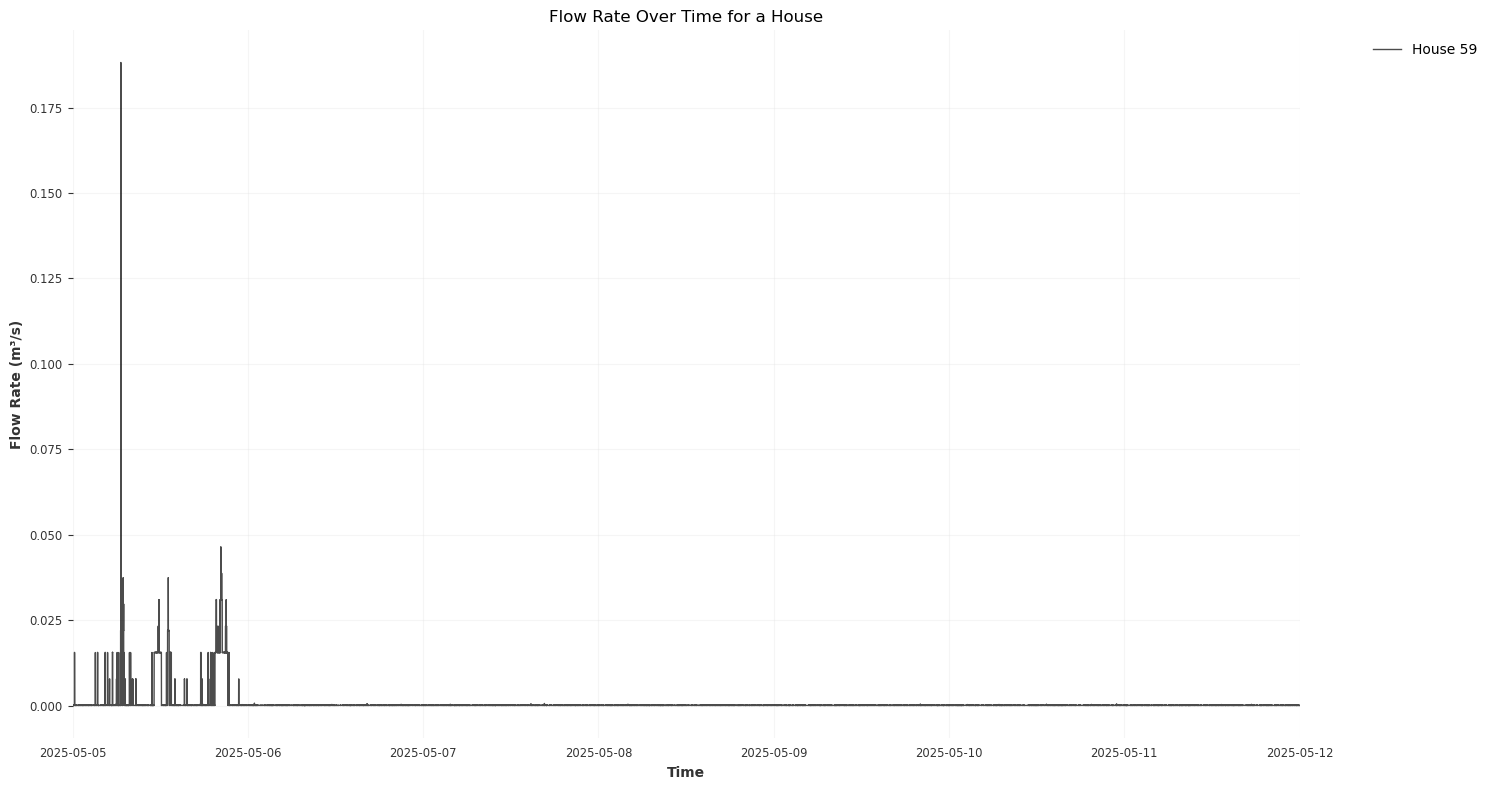

Selected house IDs: [np.int32(59)]
Total unique houses in dataset: 100
Date range for House 59: 2025-05-05 00:00 to 2025-05-12 00:00
Duration: 168.0 hours


In [30]:
unique_houses = df['house_id'].unique()
houses = np.random.choice(unique_houses, size=1, replace=False)

# Create the plot
plt.figure(figsize=(15, 8))

# Plot flow data for each random house
for house_id in houses:
    house_data = df[df['house_id'] == house_id].copy()
    house_data['timestamp'] = pd.to_datetime(house_data['timestamp'])
    house_data = house_data.sort_values('timestamp')

    start_date = house_data['timestamp'].min()
    end_date = house_data['timestamp'].max()
    
    plt.plot(house_data['timestamp'], house_data['flow_m3_s'], 
             label=f'House {house_id}', alpha=0.7, linewidth=1)

plt.xlabel('Time')
plt.ylabel('Flow Rate (m³/s)')
plt.title('Flow Rate Over Time for a House')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(start_date, end_date)
plt.tight_layout()
plt.show()

# Print the selected house IDs
print(f"Selected house IDs: {sorted(houses)}")
print(f"Total unique houses in dataset: {len(unique_houses)}")
print(f"Date range for House {houses[0]}: {start_date.strftime('%Y-%m-%d %H:%M')} to {end_date.strftime('%Y-%m-%d %H:%M')}")
print(f"Duration: {(end_date - start_date).total_seconds() / 3600:.1f} hours")

## Feature Engineering

In [31]:
feat_df = df.copy()

In [32]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6042018 entries, 0 to 6048099
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   timestamp                         datetime64[ms]
 1   house_id                          int32         
 2   flow_m3_s                         float64       
 3   flow_gpm                          float64       
 4   velocity                          float64       
 5   totalizer                         float64       
 6   pressure                          float64       
 7   downstream_wave_time              float64       
 8   upstream_wave_time                float64       
 9   delta_t_raw                       float64       
 10  theta                             float64       
 11  pipe_diameter                     float64       
 12  number_of_ultrasonic_reflections  int32         
 13  pipe_material                     object        
 14  leak                   

In [33]:
# Defining features and targets for v2
numerical_features = [
    'flow_m3_s',           # Volumetric flow (m³/s)
    'flow_gpm',            # Volumetric flow (gallons/min)
    'velocity',            # Internal pipe velocity (m/s)
    'totalizer',           # Cumulative consumption (L)
    'pressure',            # Local static pressure (kPa)
    'downstream_wave_time', # Transit-time differentials
    'upstream_wave_time',   # Transit-time differentials
    'delta_t_raw',         # Raw transit-time differential
    'theta',           # Sine of incidence angle (radians)
    'pipe_diameter',       # Internal diameter (mm)
    'number_of_ultrasonic_reflections', # Signal quality metric
    'leak',
    'time_diff_s',
    'totalizer_diff',
    'cos_theta',           # Cosine of incidence angle (radians)
    'sin_theta',
    'wall_mm',             # Wall thickness (mm) - calculated
    'id_mm',               # Internal diameter (mm) - calculated
    'L_path_mm',           # L path (mm) - calculated
    'v_est',               # Estimated velocity (m/s) - calculated
    'q_est',               # Estimated flow (m³/s) - calculated
    'velocity_error',      # Velocity estimation error - calculated
    'flow_rate_error'      # Flow rate estimation error - calculated
]

categorical_features = [
    'pipe_material',
    'location'     # e.g. 'PEX', 'Copper', 'CPVC'
]

In [34]:
feat_df.columns

Index(['timestamp', 'house_id', 'flow_m3_s', 'flow_gpm', 'velocity',
       'totalizer', 'pressure', 'downstream_wave_time', 'upstream_wave_time',
       'delta_t_raw', 'theta', 'pipe_diameter',
       'number_of_ultrasonic_reflections', 'pipe_material', 'leak', 'location',
       'time_diff_s', 'totalizer_diff', 'sin_theta', 'cos_theta', 'wall_mm',
       'id_mm', 'L_path_mm', 'v_est', 'q_est', 'velocity_error',
       'flow_rate_error'],
      dtype='object')

In [35]:
(len(numerical_features) + len(categorical_features)) == len(feat_df.columns) - 2 # Not including timestamp and house_id

True

In [36]:
# Are feature columns not in DF?
missing_numerical = [col for col in numerical_features if col not in feat_df.columns]
missing_categorical = [col for col in categorical_features if col not in feat_df.columns]

if missing_numerical:
    print(f"Missing numerical features: {missing_numerical}")
if missing_categorical:
    print(f"Missing categorical features: {missing_categorical}")

In [37]:
# Are DF columns not in features?
missing = [col for col in feat_df.columns if col not in numerical_features and col not in categorical_features]

if missing:
    print(f"Missing features: {missing}")

Missing features: ['timestamp', 'house_id']


### One-hot encoding

In [38]:
def one_hot_encodings(df):
    """Create one-hot encodings for categorical features"""
    # One-hot encode categorical features
    for cat_feature in categorical_features:
        if cat_feature in df.columns:
            # Get unique values
            unique_vals = df[cat_feature].unique()
            print(f"{cat_feature} unique values: {unique_vals}")
            
            # Create one-hot encoding
            encoded_cols = pd.get_dummies(df[cat_feature], 
                                        prefix=f'{cat_feature}_onehot', 
                                        prefix_sep='_')
            
            # Add encoded columns to dataframe
            df = pd.concat([df, encoded_cols], axis=1)
            
            print(f"Created {len(encoded_cols.columns)} columns for {cat_feature}")
    
    return df

In [39]:
feat_df = one_hot_encodings(feat_df)
feat_df.head()

pipe_material unique values: ['Copper']
Created 1 columns for pipe_material
location unique values: ['None' 'StreetConnection' 'Bathroom1' 'Meter']
Created 4 columns for location


,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,...,L_path_mm,v_est,q_est,velocity_error,flow_rate_error,pipe_material_onehot_Copper,location_onehot_Bathroom1,location_onehot_Meter,location_onehot_None,location_onehot_StreetConnection
0,2025-10-04 00:00:00,30,0.000025,0.388661,0.051558,0.002452,300.0,0.000079,0.000079,-2.673980e-09,...,7.266172,0.001566,7.623828e-07,0.969634,0.968909,True,False,False,True,False
1,2025-10-04 00:00:10,30,0.000050,0.785916,0.099587,0.007410,300.0,0.000079,0.000079,-5.437556e-09,...,7.266172,0.003184,1.550314e-06,0.968031,0.968733,True,False,False,True,False
2,2025-10-04 00:00:20,30,0.000064,1.014289,0.130590,0.013810,300.0,0.000079,0.000079,-6.951619e-09,...,7.266172,0.004070,1.981991e-06,0.968832,0.969027,True,False,False,True,False
3,2025-10-04 00:00:30,30,0.000030,0.467928,0.060022,0.016762,300.0,0.000079,0.000079,-3.325669e-09,...,7.266172,0.001947,9.481896e-07,0.967559,0.967882,True,False,False,True,False
4,2025-10-04 00:00:40,30,0.000045,0.710923,0.090176,0.021247,300.0,0.000079,0.000079,-4.953510e-09,...,7.266172,0.002900,1.412305e-06,0.967837,0.968512,True,False,False,True,False


### Forward shifting targets

In [40]:
def create_supervised_learning_targets(df, horizon="6H"):
    """
    Mark True if there's any leak in the next `horizon` (time-based, e.g. '6H'),
    regardless of irregular sampling intervals.
    """
    targets_df = feat_df.copy()
    targets_df["timestamp"] = pd.to_datetime(targets_df["timestamp"])
    targets_df = targets_df.sort_values(["house_id", "timestamp"])
    horizon = pd.to_timedelta(horizon)

    onehot_cols = [c for c in df.columns if c.startswith("location_onehot_")]
    out = []

    for _, g in df.groupby("house_id", group_keys=False):
        g = g.set_index("timestamp")

        # Forward-looking time window: reverse time, roll, then reverse back
        leak_fwd = g["leak"].astype(bool)[::-1].rolling(horizon).max()[::-1].astype(bool)
        g["leak_next_6h"] = leak_fwd

        # Branch-specific: only flag when leak happens on that branch
        for col in onehot_cols:
            s = (g[col].astype(bool) & g["leak"].astype(bool))
            g[f"{col}_next_6h"] = s[::-1].rolling(horizon).max()[::-1].astype(bool)

        out.append(g.reset_index())

    res = pd.concat(out, ignore_index=True)

    # "none" = True only when no leak predicted at all
    none_col = f"location_onehot_none_next_{horizon}"
    if none_col in res.columns:
        res[none_col] = ~res[f"leak_next_{horizon}"].astype(bool)
    else:
        # create it if you want it regardless of prior columns:
        # res[none_col] = ~res[f"leak_next_{horizon}"].astype(bool)
        pass

    return res

In [41]:
feat_df = create_supervised_learning_targets(feat_df)
feat_df.head()

/var/folders/7y/c70b2kjs6bdfsmfnvfrmypnh0000gn/T/ipykernel_85151/1983035882.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  horizon = pd.to_timedelta(horizon)


,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,...,pipe_material_onehot_Copper,location_onehot_Bathroom1,location_onehot_Meter,location_onehot_None,location_onehot_StreetConnection,leak_next_6h,location_onehot_Bathroom1_next_6h,location_onehot_Meter_next_6h,location_onehot_None_next_6h,location_onehot_StreetConnection_next_6h
0,2025-07-27 00:00:00,1,0.000028,0.450066,0.036256,0.002839,300.0,0.000079,0.000079,-1.960312e-09,...,True,False,False,True,False,False,False,False,False,False
1,2025-07-27 00:00:10,1,0.000022,0.349987,0.054417,0.005048,300.0,0.000079,0.000079,-2.963398e-09,...,True,False,False,True,False,False,False,False,False,False
2,2025-07-27 00:00:20,1,0.000008,0.130518,0.012378,0.005871,300.0,0.000079,0.000079,-7.283438e-10,...,True,False,False,True,False,False,False,False,False,False
3,2025-07-27 00:00:30,1,0.000026,0.406569,0.057671,0.008436,300.0,0.000079,0.000079,-3.118134e-09,...,True,False,False,True,False,False,False,False,False,False
4,2025-07-27 00:00:40,1,0.000021,0.325417,0.037359,0.010489,300.0,0.000079,0.000079,-2.039879e-09,...,True,False,False,True,False,False,False,False,False,False


In [42]:
feat_df[feat_df['leak_next_6h'] == True]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,...,pipe_material_onehot_Copper,location_onehot_Bathroom1,location_onehot_Meter,location_onehot_None,location_onehot_StreetConnection,leak_next_6h,location_onehot_Bathroom1_next_6h,location_onehot_Meter_next_6h,location_onehot_None_next_6h,location_onehot_StreetConnection_next_6h
737256,2025-09-01 09:54:40,13,0.000124,1.961088,0.057668,1857.631515,300.0,0.000079,0.000079,-3.109870e-09,...,True,False,False,True,False,True,True,False,False,False
737257,2025-09-01 09:54:50,13,0.000044,0.693533,0.060635,1857.635891,300.0,0.000079,0.000079,-3.263715e-09,...,True,False,False,True,False,True,True,False,False,False
737258,2025-09-01 09:55:00,13,-0.000025,-0.401815,0.038793,1857.633356,300.0,0.000079,0.000079,-1.952742e-09,...,True,False,False,True,False,True,True,False,False,False
737259,2025-09-01 09:55:10,13,-0.000051,-0.805091,0.057400,1857.628276,300.0,0.000079,0.000079,-3.164598e-09,...,True,False,False,True,False,True,True,False,False,False
737260,2025-09-01 09:55:20,13,-0.000061,-0.963182,0.076864,1857.622200,300.0,0.000079,0.000079,-4.203035e-09,...,True,False,False,True,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229371,2025-10-01 23:59:20,70,0.000130,2.054516,0.260850,3124.171661,300.0,0.000079,0.000079,-1.390632e-08,...,True,False,False,False,True,True,False,False,False,True
4229372,2025-10-01 23:59:30,70,0.000133,2.102598,0.274084,3124.184926,300.0,0.000079,0.000079,-1.462885e-08,...,True,False,False,False,True,True,False,False,False,True
4229373,2025-10-01 23:59:40,70,0.000136,2.155026,0.265668,3124.198523,300.0,0.000079,0.000079,-1.419712e-08,...,True,False,False,False,True,True,False,False,False,True
4229374,2025-10-01 23:59:50,70,0.000117,1.852696,0.255117,3124.210211,300.0,0.000079,0.000079,-1.370667e-08,...,True,False,False,False,True,True,False,False,False,True


### Target distribution analysis

In [43]:
print("\n1. OVERALL LEAK STATISTICS")
print("-"*40)

total_samples = len(feat_df)
leak_samples = feat_df['leak'].sum()
leak_rate = leak_samples / total_samples

print(f"Total samples: {total_samples:,}")
print(f"Leak samples: {leak_samples:,}")
print(f"No-leak samples: {total_samples - leak_samples:,}")
print(f"Overall leak rate: {leak_rate:.4f} ({leak_rate*100:.2f}%)")
print(f"Class imbalance ratio: {(total_samples - leak_samples) / leak_samples:.1f}:1 (no-leak:leak)")


1. OVERALL LEAK STATISTICS
----------------------------------------
Total samples: 6,042,018
Leak samples: 115,840
No-leak samples: 5,926,178
Overall leak rate: 0.0192 (1.92%)
Class imbalance ratio: 51.2:1 (no-leak:leak)


In [44]:
print("\n2. PER-HOUSE LEAK DISTRIBUTION")
print("-"*40)

house_leak_stats = []
for house_id in sorted(feat_df['house_id'].unique()):
    house_data = feat_df[feat_df['house_id'] == house_id]
    house_total = len(house_data)
    house_leaks = house_data['leak'].sum()
    house_leak_rate = house_leaks / house_total if house_total > 0 else 0
    
    house_leak_stats.append({
        'house_id': house_id,
        'total_samples': house_total,
        'leak_samples': house_leaks,
        'leak_rate': house_leak_rate
    })

house_stats_df = pd.DataFrame(house_leak_stats)

print(f"Houses with leaks: {(house_stats_df['leak_samples'] > 0).sum()}")
print(f"Houses without leaks: {(house_stats_df['leak_samples'] == 0).sum()}")
print(f"Average leak rate per house: {house_stats_df['leak_rate'].mean():.4f}")
print(f"Std leak rate per house: {house_stats_df['leak_rate'].std():.4f}")
print(f"Min leak rate: {house_stats_df['leak_rate'].min():.4f}")
print(f"Max leak rate: {house_stats_df['leak_rate'].max():.4f}")


2. PER-HOUSE LEAK DISTRIBUTION
----------------------------------------
Houses with leaks: 4
Houses without leaks: 96
Average leak rate per house: 0.0192
Std leak rate per house: 0.1050
Min leak rate: 0.0000
Max leak rate: 0.7625


In [45]:
print("\n3. LEAK RATE THRESHOLD ANALYSIS (20%)")
print("-"*40)

threshold = 0.15  # 20%
houses_over_threshold = house_stats_df[house_stats_df['leak_rate'] > threshold]
houses_at_or_below_threshold = house_stats_df[house_stats_df['leak_rate'] <= threshold]

print(f"Houses with leak rate > 15%: {len(houses_over_threshold)}")
print(f"Houses with leak rate ≤ 15%: {len(houses_at_or_below_threshold)}")
print(f"Percentage of houses > 15%: {len(houses_over_threshold) / len(house_stats_df) * 100:.2f}%")
print(f"Percentage of houses ≤ 15%: {len(houses_at_or_below_threshold) / len(house_stats_df) * 100:.2f}%")

# Show houses with highest leak rates
print(f"\nTop 10 houses by leak rate:")
top_leak_houses = house_stats_df.nlargest(10, 'leak_rate')
for _, row in top_leak_houses.iterrows():
    print(f"House {row['house_id']}: {row['leak_samples']}/{row['total_samples']} = {row['leak_rate']:.4f}")

# Show houses over 20% threshold
if len(houses_over_threshold) > 0:
    print(f"\nHouses with leak rate > 15%:")
    for _, row in houses_over_threshold.iterrows():
        print(f"House {row['house_id']}: {row['leak_samples']}/{row['total_samples']} = {row['leak_rate']:.4f}")
else:
    print(f"\nNo houses have leak rate > 15%")


3. LEAK RATE THRESHOLD ANALYSIS (20%)
----------------------------------------
Houses with leak rate > 15%: 3
Houses with leak rate ≤ 15%: 97
Percentage of houses > 15%: 3.00%
Percentage of houses ≤ 15%: 97.00%

Top 10 houses by leak rate:
House 13.0: 46073.0/60422.0 = 0.7625
House 33.0: 33240.0/60421.0 = 0.5501
House 16.0: 28817.0/60439.0 = 0.4768
House 70.0: 7710.0/60429.0 = 0.1276
House 1.0: 0.0/60404.0 = 0.0000
House 2.0: 0.0/60418.0 = 0.0000
House 3.0: 0.0/60425.0 = 0.0000
House 4.0: 0.0/60427.0 = 0.0000
House 5.0: 0.0/60437.0 = 0.0000
House 6.0: 0.0/60416.0 = 0.0000

Houses with leak rate > 15%:
House 13.0: 46073.0/60422.0 = 0.7625
House 16.0: 28817.0/60439.0 = 0.4768
House 33.0: 33240.0/60421.0 = 0.5501


## Filtering DF for unrealistic leak % and duplicates

In [46]:
# 4. CREATE FILTERED DATAFRAME
print("\n4. CREATE FILTERED DATAFRAME")
print("-"*40)

# Get house IDs to keep (those with leak rate <= threshold)
houses_to_keep = houses_at_or_below_threshold['house_id'].tolist()

# Create filtered DataFrame
filtered_df = feat_df[feat_df['house_id'].isin(houses_to_keep)].copy()

print(f"Original dataset size: {len(feat_df):,} rows")
print(f"Filtered dataset size: {len(filtered_df):,} rows")
print(f"Removed {len(feat_df) - len(filtered_df):,} rows")
print(f"Removed {len(houses_over_threshold)} houses with leak rate > {threshold*100}%")

# Verify the filtering worked correctly
print(f"\nVerification:")
print(f"Remaining houses: {filtered_df['house_id'].nunique()}")
print(f"Removed houses: {len(houses_over_threshold)}")

# Check leak rate in filtered dataset
filtered_total = len(filtered_df)
filtered_leaks = filtered_df['leak'].sum()
filtered_leak_rate = filtered_leaks / filtered_total if filtered_total > 0 else 0

print(f"Filtered dataset leak rate: {filtered_leak_rate:.4f} ({filtered_leak_rate*100:.2f}%)")
print(f"Original dataset leak rate: {leak_rate:.4f} ({leak_rate*100:.2f}%)")


4. CREATE FILTERED DATAFRAME
----------------------------------------
Original dataset size: 6,042,018 rows
Filtered dataset size: 5,860,736 rows
Removed 181,282 rows
Removed 3 houses with leak rate > 15.0%

Verification:
Remaining houses: 97
Removed houses: 3
Filtered dataset leak rate: 0.0013 (0.13%)
Original dataset leak rate: 0.0192 (1.92%)


In [47]:
dupes_mask = filtered_df.duplicated(subset=['house_id', 'timestamp'], keep=False)

# How many duplicates overall
print(f"Total duplicate rows: {dupes_mask.sum():,}")

# Count duplicates per house (only the problematic ones)
dupes_per_house = (
    filtered_df.loc[dupes_mask, ['house_id', 'timestamp']]
    .groupby('house_id')
    .size()
    .sort_values(ascending=False)
)

print("\nTop houses with duplicate timestamps:")
print(dupes_per_house.head(10))

# Inspect a specific house to verify:
sample_house = dupes_per_house.index[0] if not dupes_per_house.empty else None
if sample_house is not None:
    display(
        filtered_df[filtered_df['house_id'] == sample_house]
        .loc[lambda d: d.duplicated(subset='timestamp', keep=False)]
        .sort_values('timestamp')
        .head(20)
    )

Total duplicate rows: 0

Top houses with duplicate timestamps:
Series([], dtype: int64)


In [48]:
before = len(filtered_df)

dup_df = (
    filtered_df
    .sort_values(['house_id', 'timestamp'])
    .drop_duplicates(subset=['house_id', 'timestamp'],
                     keep='first')
    .reset_index(drop=True)
)

after = len(filtered_df)
print(f"Removed {before - after:,} duplicate rows "
      f"({before:,} → {after:,})")

Removed 0 duplicate rows (5,860,736 → 5,860,736)


In [49]:
filtered_df.columns

Index(['timestamp', 'house_id', 'flow_m3_s', 'flow_gpm', 'velocity',
       'totalizer', 'pressure', 'downstream_wave_time', 'upstream_wave_time',
       'delta_t_raw', 'theta', 'pipe_diameter',
       'number_of_ultrasonic_reflections', 'pipe_material', 'leak', 'location',
       'time_diff_s', 'totalizer_diff', 'sin_theta', 'cos_theta', 'wall_mm',
       'id_mm', 'L_path_mm', 'v_est', 'q_est', 'velocity_error',
       'flow_rate_error', 'pipe_material_onehot_Copper',
       'location_onehot_Bathroom1', 'location_onehot_Meter',
       'location_onehot_None', 'location_onehot_StreetConnection',
       'leak_next_6h', 'location_onehot_Bathroom1_next_6h',
       'location_onehot_Meter_next_6h', 'location_onehot_None_next_6h',
       'location_onehot_StreetConnection_next_6h'],
      dtype='object')

## Features and Targets

In [50]:
import re
def infer_horizon(df, default=6):
    for c in df.columns:
        m = re.match(r'^leak_next_(\d+)h$', c)
        if m:
            return int(m.group(1))
    return default

In [51]:
def auto_targets(df, horizon=None):
    h = infer_horizon(df) if horizon is None else horizon
    suffix = f"_next_{h}h"
    binary = f"leak_next_{h}h"
    if binary not in df.columns:
        raise ValueError(f"Binary target '{binary}' not found in dataframe.")
    onehots = [c for c in df.columns
               if c.startswith("location_onehot_") and c.endswith(suffix)]
    return [binary] + sorted(onehots)

In [52]:
def auto_features(df, horizon=None, metadata_cols=None, extra_exclude=None):
    h = infer_horizon(df) if horizon is None else horizon
    suffix = f"_next_{h}h"

    # defaults
    metadata_cols = (['timestamp', 'house_id'] if metadata_cols is None else list(metadata_cols))
    extra_exclude = set(extra_exclude or [])

    exclude_exact = {'pressure'} | extra_exclude
    exclude_prefixes = ('location_onehot_', 'v_est', 'q_est')
    exclude_suffixes = (suffix, '_error', '_pass')

    def is_feature(col: str) -> bool:
        if col in metadata_cols: return False
        if col in exclude_exact: return False
        if col in categorical_features: return False
        if col == 'pressure': return False
        if any(col.startswith(p) for p in exclude_prefixes): return False
        if any(col.endswith(s) for s in exclude_suffixes): return False
        return True

    # Keep original column order
    return [c for c in df.columns if is_feature(c)]

In [53]:
TARGETS = auto_targets(filtered_df) 
FEATURES = auto_features(filtered_df)

print(f"# of features: {len(FEATURES):,}")
print(f"Features: {FEATURES} cols")
print(f"# of targets: {len(TARGETS):,}")
print(f"Targets:  {TARGETS} cols")

# of features: 19
Features: ['flow_m3_s', 'flow_gpm', 'velocity', 'totalizer', 'downstream_wave_time', 'upstream_wave_time', 'delta_t_raw', 'theta', 'pipe_diameter', 'number_of_ultrasonic_reflections', 'leak', 'time_diff_s', 'totalizer_diff', 'sin_theta', 'cos_theta', 'wall_mm', 'id_mm', 'L_path_mm', 'pipe_material_onehot_Copper'] cols
# of targets: 5
Targets:  ['leak_next_6h', 'location_onehot_Bathroom1_next_6h', 'location_onehot_Meter_next_6h', 'location_onehot_None_next_6h', 'location_onehot_StreetConnection_next_6h'] cols


In [54]:
filtered_df.shape

(5860736, 37)

### Extra NA dropping for targets

In [55]:
target_filtered = filtered_df.copy()
drop_cols = FEATURES + TARGETS
target_filtered[target_filtered[drop_cols].isna().any(axis=1)]

,timestamp,house_id,flow_m3_s,flow_gpm,velocity,totalizer,pressure,downstream_wave_time,upstream_wave_time,delta_t_raw,...,pipe_material_onehot_Copper,location_onehot_Bathroom1,location_onehot_Meter,location_onehot_None,location_onehot_StreetConnection,leak_next_6h,location_onehot_Bathroom1_next_6h,location_onehot_Meter_next_6h,location_onehot_None_next_6h,location_onehot_StreetConnection_next_6h


In [56]:
target_filtered.shape

(5860736, 37)

## Scaling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import joblib, os
from datetime import datetime

folder_timestamp = datetime.now().strftime("%Y%m%d")
file_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

def scale_features_tcn(df, scaler_path=None):
    """
    - Uses sin/cos for angle (assumes theta is in radians; if in degrees, convert first).
    - Applies log1p to skewed, non-negative features (idempotent with inference if you reload bundle).
    - Scales a fixed list of numeric cols with a single global RobustScaler.
    - Saves a bundle: {'scaler', 'cols', 'log1p_cols'} for consistent inference.
    """
    df = df.copy()

    log1p_candidates = [
        'flow_m3_s', 'flow_gpm', 'velocity',
        'downstream_wave_time', 'upstream_wave_time', 'delta_t_raw',
        'totalizer_diff', 'time_diff_s'
    ]
    log1p_cols = [c for c in log1p_candidates if c in df.columns]

    for c in log1p_cols:
        df[c] = np.log1p(df[c].clip(lower=0))

    numerical_features = [
        'flow_m3_s', 'flow_gpm', 'velocity', 'totalizer_diff',
        'downstream_wave_time', 'upstream_wave_time', 'delta_t_raw',
        'pipe_diameter', 'number_of_traverses',
        'wall_mm', 'id_mm', 'L_path_mm', 'time_diff_s',
        'theta_sin', 'theta_cos'
    ]
    cols_present = [c for c in numerical_features if c in df.columns]

    scaler = RobustScaler()
    df[cols_present] = scaler.fit_transform(df[cols_present])

    if scaler_path is None:
        scaler_path = f'weights/{folder_timestamp}/{file_timestamp}/feature_scaler.pkl'
    os.makedirs(os.path.dirname(scaler_path), exist_ok=True)
    bundle = {
        'scaler': scaler,
        'cols': cols_present,
        'log1p_cols': log1p_cols,
        'timestamp': folder_timestamp,
    }

    joblib.dump(bundle, scaler_path)
    print(f"Saved global scaler bundle to {scaler_path}")

    if cols_present:
        print("\nScaling statistics (post-transform):")
        for col in cols_present:
            col_mean = df[col].mean()
            col_std  = df[col].std(ddof=1)  # sample std
            print(f"{col}: mean={col_mean:.3f}, std={col_std:.3f}")
    else:
        print("No scaling statistics to show (no columns were scaled).")

    return df, bundle

In [58]:
scaled_df, feature_scaler = scale_features_tcn(target_filtered)

Saved global scaler bundle to weights/20250808/20250808_182521/feature_scaler.pkl

Scaling statistics (post-transform):
flow_m3_s: mean=10.107, std=79.194
flow_gpm: mean=0.328, std=2.108
velocity: mean=1.048, std=6.591
totalizer_diff: mean=5.297, std=37.528
downstream_wave_time: mean=-10.090, std=78.755
upstream_wave_time: mean=10.477, std=82.751
delta_t_raw: mean=0.000, std=0.000
pipe_diameter: mean=0.000, std=0.000
number_of_ultrasonic_reflections: mean=0.464, std=0.499
wall_mm: mean=0.000, std=0.000
id_mm: mean=0.000, std=0.000
L_path_mm: mean=0.464, std=0.499
time_diff_s: mean=0.001, std=0.041


### Covert to float32 for darts compatibility

In [59]:
float64_cols = scaled_df.select_dtypes(include=['float64']).columns
scaled_df[float64_cols] = scaled_df[float64_cols].astype('float32')

## Darts timeseries objects

In [60]:
house_feature_series   = {} # id -> TimeSeries of covariates
house_target_series    = {} # id -> TimeSeries of targetsv

In [61]:
def regularize_timeseries(
    df,
    time_col='timestamp',
    freq='10s',
    num_cols=FEATURES,
    cat_cols=categorical_features,
    target_cols=TARGETS,
    how='last'
):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df.dropna(subset=[time_col]).sort_values(time_col).set_index(time_col)

    agg_map = {c: how for c in num_cols if c in df.columns}
    if cat_cols:
        agg_map.update({c: 'last' for c in cat_cols if c in df.columns})
    if target_cols:
        # for boolean targets, keep True if any True within the bin
        agg_map.update({c: 'max' for c in target_cols if c in df.columns})

    binned = df.resample(freq).agg(agg_map)

    # imputation flags for numeric only
    imputed_flags = {}
    for c in num_cols:
        if c in binned.columns:
            imputed_flags[f'{c}_imputed'] = binned[c].isna()

    # fill numeric
    present_num = [c for c in num_cols if c in binned.columns]
    if present_num:
        binned[present_num] = binned[present_num].interpolate(method='time', limit_direction='both')

    # fill categoricals only
    present_cat = [c for c in (cat_cols or []) if c in binned.columns]
    if present_cat:
        binned[present_cat] = binned[present_cat].ffill().bfill()

    # cast/clean targets; avoid filling from neighbors to prevent leakage
    if target_cols:
        present_tgt = [c for c in target_cols if c in binned.columns]
        if present_tgt:
            binned[present_tgt] = binned[present_tgt].fillna(False).astype(bool)

    # attach numeric imputation flags
    for flag_name, mask in imputed_flags.items():
        binned[flag_name] = mask.astype(int)

    binned = binned.reset_index().rename(columns={'index': time_col})
    return binned


In [62]:
freq ='10s'

for hid, group in scaled_df.groupby('house_id', sort=False):
    clean = regularize_timeseries(group)

    feat_ts = TimeSeries.from_dataframe(
        clean, time_col='timestamp', value_cols=FEATURES, freq=freq
    ).with_static_covariates(pd.DataFrame({'house_id':[hid]})).astype(np.float32)

    targ_ts = TimeSeries.from_dataframe(
        clean, time_col='timestamp', value_cols=TARGETS, freq=freq
    ).with_static_covariates(pd.DataFrame({'house_id':[hid]})).astype(np.float32)
    
    # Store
    house_feature_series[hid] = feat_ts
    house_target_series[hid]  = targ_ts

print(f"Built {len(house_feature_series)} house TimeSeries objects")

Built 97 house TimeSeries objects


## Cross validation

In [63]:
# Convert the dicts built earlier into reproducible ordered lists
house_ids = np.array(sorted(house_feature_series.keys()))
feat_series_list = [house_feature_series[h] for h in house_ids]
targ_series_list = [house_target_series[h]  for h in house_ids]

print(f"Total houses: {len(house_ids)}")

Total houses: 97


In [64]:
from sklearn.model_selection import StratifiedGroupKFold, TimeSeriesSplit

# CV configuration
cv = StratifiedGroupKFold(n_splits=5) 

In [65]:
# TCN hyper-parameters
INPUT_CHUNK  = (6 * 60 * 24 * 3) # 1 week history, 10s intervals (6 10s intervals per minute, 60 minutes per hour, 24 hours per day, 7 days)
OUTPUT_CHUNK = (6 * 60 * 6) # 6h forecast horizon, 10 s intervals (6 10s intervals per minute, 60 minutes per hour, 6 hours)
N_EPOCHS = 8
BATCH_SIZE = 16
NUM_LAYERS = 6
NUM_FILTERS = 32
KERNEL_SIZE = 5
DILATION = 3
DROPOUT = 0.1

In [68]:
from darts.utils.likelihood_models.torch import BernoulliLikelihood

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    precision_score, recall_score, f1_score
)

def run_fold(train_idx, test_idx, fold_no):
    """
    Train on `train_idx` houses, validate on the last OUTPUT_CHUNK of each
    remaining house, and evaluate on `test_idx`.

    Houses whose time-series are shorter than the minimum length required by
    Darts (INPUT_CHUNK + OUTPUT_CHUNK) are skipped (“dropped out”).
    """
    # Gather per-house series lists
    train_feats_outer = [feat_series_list[i] for i in train_idx]
    train_targ_outer = [targ_series_list[i] for i in train_idx]
    test_feats_outer = [feat_series_list[i] for i in test_idx]
    test_targ_outer = [targ_series_list[i] for i in test_idx]

    # Minimum length of the portion fed to model.fit()
    MIN_TRAIN_LEN = INPUT_CHUNK + OUTPUT_CHUNK # 7 days + 24 h = 768

    # Build training / validation sets, dropping houses with too few points
    train_feats, train_targs, val_feats, val_targs = [], [], [], []
    dropped = 0

    for feats_ts, targ_ts in zip(train_feats_outer, train_targ_outer):
        n_points = len(targ_ts)

        # Need MIN_TRAIN_LEN for fitting + OUTPUT_CHUNK for validation chunk
        if n_points < MIN_TRAIN_LEN + OUTPUT_CHUNK:
            dropped += 1
            continue
        
        VAL_WINDOW = INPUT_CHUNK + OUTPUT_CHUNK 
        split_idx = n_points - VAL_WINDOW
        train_feats.append(feats_ts[:split_idx])
        train_targs.append(targ_ts[:split_idx])
        val_feats.append(feats_ts[split_idx:])
        val_targs.append(targ_ts[split_idx:])

    if dropped:
        print(f"Dropped {dropped} train houses that were < "
              f"{MIN_TRAIN_LEN + OUTPUT_CHUNK} points long")

    # Define and fit the TCN
    model = TCNModel(
        input_chunk_length = INPUT_CHUNK,
        output_chunk_length = OUTPUT_CHUNK,
        output_chunk_shift = 0,
        likelihood = BernoulliLikelihood(), 
        n_epochs = N_EPOCHS,
        batch_size = BATCH_SIZE,
        num_layers = NUM_LAYERS,
        num_filters = NUM_FILTERS,
        kernel_size = KERNEL_SIZE,
        dilation_base = DILATION,
        dropout = DROPOUT,
        random_state = 42,
    )

    t0 = time.time()
    model.fit(series=train_targs,
            past_covariates=train_feats,
            val_series=val_targs,
            val_past_covariates=val_feats,
            max_samples_per_ts=5,
            verbose=True)
    fit_secs = time.time() - t0

    # Evaluate
    y_true, y_pred = [], []
    for feats_ts, targ_ts in zip(test_feats_outer, test_targ_outer):
        if len(targ_ts) < INPUT_CHUNK + OUTPUT_CHUNK:
            continue  # nothing to predict safely
        hist = targ_ts[:-OUTPUT_CHUNK]
        future = targ_ts[-OUTPUT_CHUNK:] 

        preds = model.predict(n=OUTPUT_CHUNK,
                              series=hist,
                              past_covariates=feats_ts)

        y_true.extend(future.values()[:, 0]) # first dim = burst_leak flag
        y_pred.extend(preds .values()[:, 0])

    auc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)
    brier = brier_score_loss(y_true, y_pred)

    y_pred_bin = (np.asarray(y_pred) >= 0.5).astype(int)
    precision = precision_score(y_true, y_pred_bin, zero_division=0)
    recall = recall_score(y_true, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true, y_pred_bin, zero_division=0)
    print(
        f"Fold {fold_no} |  PR-AUC {pr_auc:.4f}  "
        f"LBrier {brier:.4f}  Precision {precision:.3f} \n"
        f"Recall {recall:.3f}  F1 {f1:.3f}  "
        f"(fit {fit_secs/60:.1f} min)"
    )
    
    total_houses = len(house_ids)  # Total houses in dataset
    train_houses = len(train_idx)  # Houses used for training
    test_houses = len(test_idx)    # Houses used for testing
    
    # Create timestamp and folder name with dataset info
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"{folder_timestamp}/{file_timestamp}/fold{fold_no}_{train_houses}train_{test_houses}test"
    folder_path = f"weights/{folder_name}"
    
    # Create the folder
    os.makedirs(folder_path, exist_ok=True)
    
    # Save the model
    model.save(f"{folder_path}/tcn_fold{fold_no}_{timestamp}.pt")
    
    print(f"Saved model to {folder_path}/tcn_fold{fold_no}_{timestamp}.pt")

    # Clean-up
    del model
    gc.collect()

    return {
        "fold": fold_no,
        "PR_AUC": pr_auc,
        "Brier": brier,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "fit_seconds": fit_secs
    }

In [69]:
results = []
house_labels = np.array([int(ts.values()[:, 0].any()) for ts in house_target_series.values()])

for fold_no, (train_idx, test_idx) in enumerate(
        cv.split(X=house_ids, y=house_labels, groups=house_ids), start=1):
    print(f"\n===== FOLD {fold_no}/5 "
          f"— train houses {len(train_idx)}, test houses {len(test_idx)} =====")
    fold_result = run_fold(train_idx, test_idx, fold_no)
    results.append(fold_result)

/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 57.2 K | train
-------------------------------------------------------------
57.2 K    Trainable params
0         Non-trainable params
57.2 K    Total params
0.229     Total estimated model params size (MB)
38        Modules in train mod


===== FOLD 1/5 — train houses 77, test houses 20 =====
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.85it/s, train_loss=3.46e-10, val_loss=0.0315]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.85it/s, train_loss=3.46e-10, val_loss=0.0315]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 349.26it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 350.49it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 272.84it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 315.24it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 351.37it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 354.13it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 342.34it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 340.83it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 263.99it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 309.79it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 349.99it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 335.22it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.11it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 273.07it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 273.30it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 279.58it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 265.66it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.72it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 259.61it/s]


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Fold 1 |  PR-AUC 0.0000  LBrier 0.0000  Precision 0.000 
Recall 0.000  F1 0.000  (fit 0.6 min)
Saved model to weights/20250808/20250808_182521/fold1_77train_20test/tcn_fold1_20250808_182757.pt

===== FOLD 2/5 — train houses 78, test houses 19 =====


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 57.2 K | train
-------------------------------------------------------------
57.2 K    Trainable params
0         Non-trainable params
57.2 K    Total params
0.229     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.73it/s, train_loss=0.000, val_loss=0.0311]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.73it/s, train_loss=0.000, val_loss=0.0311]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 358.43it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 270.36it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.07it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 318.89it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 343.51it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 331.91it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 298.51it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 284.26it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 353.83it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 326.35it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 260.71it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 324.49it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.78it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 338.88it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 341.19it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.99it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 297.70it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 315.76it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 339.45it/s]


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Fold 2 |  PR-AUC 0.0000  LBrier 0.0000  Precision 0.000 
Recall 0.000  F1 0.000  (fit 0.6 min)
Saved model to weights/20250808/20250808_182521/fold2_78train_19test/tcn_fold2_20250808_182832.pt

===== FOLD 3/5 — train houses 78, test houses 19 =====


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 57.2 K | train
-------------------------------------------------------------
57.2 K    Trainable params
0         Non-trainable params
57.2 K    Total params
0.229     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.78it/s, train_loss=0.000, val_loss=0.0311]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.78it/s, train_loss=0.000, val_loss=0.0311]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 341.08it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 354.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 326.13it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 290.02it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 347.70it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 357.51it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 325.52it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 289.68it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 331.99it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.12it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 265.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 334.69it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 315.86it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 287.85it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 294.21it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 354.73it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 344.13it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 307.79it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 293.84it/s]


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Fold 3 |  PR-AUC 0.0000  LBrier 0.0000  Precision 0.000 
Recall 0.000  F1 0.000  (fit 0.6 min)
Saved model to weights/20250808/20250808_182521/fold3_78train_19test/tcn_fold3_20250808_182908.pt

===== FOLD 4/5 — train houses 77, test houses 20 =====


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 57.2 K | train
-------------------------------------------------------------
57.2 K    Trainable params
0         Non-trainable params
57.2 K    Total params
0.229     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.58it/s, train_loss=1.55e-9, val_loss=0.000]    

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 25/25 [00:04<00:00,  5.58it/s, train_loss=1.55e-9, val_loss=0.000]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 325.09it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 344.02it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.56it/s]

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 262.46it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 298.25it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 271.74it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 340.72it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 271.32it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 309.31it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.37it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 335.60it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 335.68it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 311.13it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 325.42it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 279.55it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 345.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.37it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 275.94it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 302.86it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 292.41it/s]
Fold 4 |  PR-AUC 0.0500  LBrier 0.0500  Precision 0.000 
Recall 0.000  F1 0.000  (fit 0.6 min)
Saved model to weights/20250808/20250808_182521/fold4_77train_20test/tcn_fold4_20250808_182943.pt

===== FOLD 5/5 — train houses 78, test houses 19 =====


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 57.2 K | train
-------------------------------------------------------------
57.2 K    Trainable params
0         Non-trainable params
57.2 K    Total params
0.229     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 7: 100%|██████████| 25/25 [00:05<00:00,  4.91it/s, train_loss=0.000, val_loss=0.0311]   

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 25/25 [00:05<00:00,  4.91it/s, train_loss=0.000, val_loss=0.0311]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 348.89it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 349.15it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 326.25it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 347.84it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 339.32it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.78it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 359.32it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 361.17it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 313.99it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 365.64it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 327.96it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 363.77it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 325.92it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 366.41it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 352.26it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 342.22it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 335.79it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 362.95it/s]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 336.22it/s]


/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/WDN_sim/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Fold 5 |  PR-AUC 0.0000  LBrier 0.0000  Precision 0.000 
Recall 0.000  F1 0.000  (fit 0.6 min)
Saved model to weights/20250808/20250808_182521/fold5_78train_19test/tcn_fold5_20250808_183021.pt


In [71]:
print("\n========== CV SUMMARY ==========")
summary_df = pd.DataFrame(results)
display(summary_df)

metric_cols = ["PR_AUC", "Brier", "Precision", "Recall", "F1"]

mean_vals = summary_df[metric_cols].mean()
print("Mean metrics across folds:")
for m, v in mean_vals.items():
    print(f" • {m:10s}: {v:.4f}")

# Save with all columns
summary_df.to_json(f"weights/{folder_timestamp}/{file_timestamp}/cv_results_250.json", orient="records", indent=2)
print("Saved per-fold metrics to cv_results_250.json")


========== CV SUMMARY ==========


,fold,PR_AUC,Brier,Precision,Recall,F1,fit_seconds
0,1,0.000000,0.000000,0.0,0.0,0.0,34.498718
1,2,0.000000,0.000000,0.0,0.0,0.0,34.966160
2,3,0.000000,0.000000,0.0,0.0,0.0,34.964677
3,4,0.049977,0.049977,0.0,0.0,0.0,34.750399
4,5,0.000000,0.000000,0.0,0.0,0.0,37.540767


Mean metrics across folds:
 • PR_AUC    : 0.0100
 • Brier     : 0.0100
 • Precision : 0.0000
 • Recall    : 0.0000
 • F1        : 0.0000
Saved per-fold metrics to cv_results_250.json
